 in this notebook we summarize the findings we came to in the "Exploratory_Analysis".

 ## 1.Data Analysis
  from analyzing the data relative to the label 'smoking' we were able to identify certain faetures that correlate the most to the label.
  - 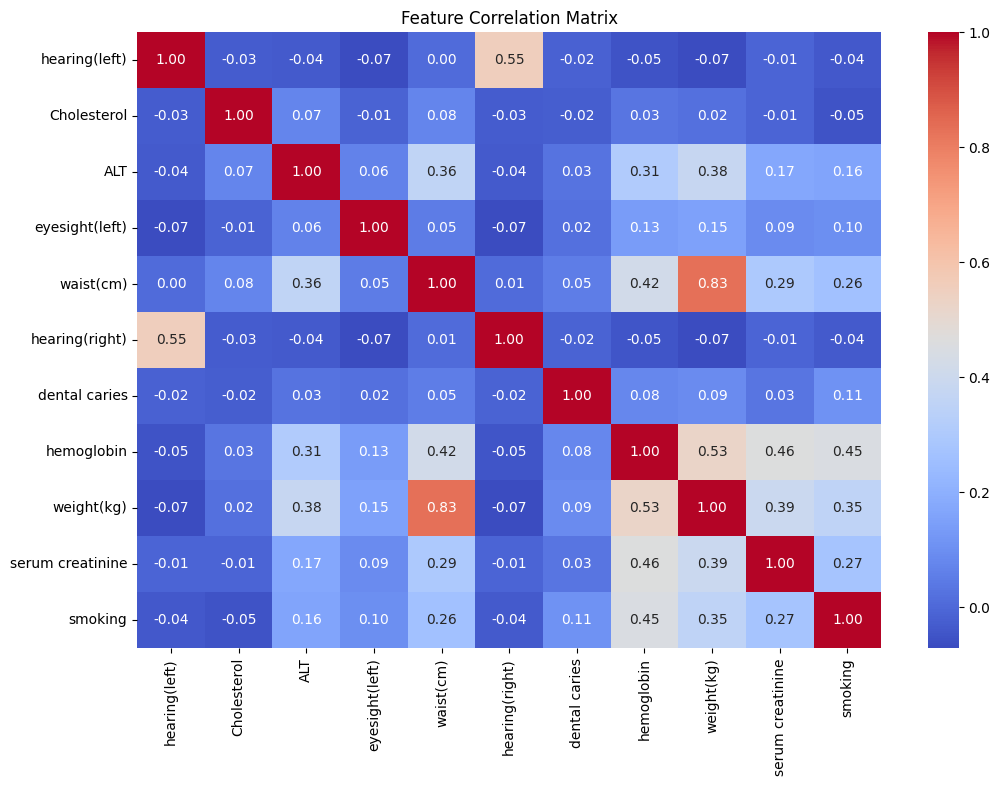

we concluded that the four most correlated features with smoking are serum creatinine, weight, hemoglobin, waist. 

multivariate analysis showed that hearing left, hearing right , and dental carries contribute very little. we might drop them for dimensionality reduction.

## 2. Feature Engineering
 we concluded that we could reduce the dimensionality only to four features while maintaing the same information with regard to the label.
 we then engineered a new feature that slightly improved the model accuracy.

## 3.Ensemble Methods
we created a class for each of the ensemble methods

## 4. Hyperparametr tuning

In [8]:
import random
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Load the generated dataset
df = pd.read_csv("MyData_updated.csv") 

# Separate features and target
X = df.drop(columns=['smoking'])  # drop all except(waist, hemoglobin, weight, serum creatinine)
y = df['smoking']



In [2]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# Convert X and y to numpy arrays for clarity
X_scaled = np.array(X_scaled)
y = np.array(y)


In [4]:
# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Verify shapes
print("Training set size:", X_scaled.shape)
print("Validation set size:", X_valid.shape)
print("Test set size:", X_test.shape)


Training set size: (159256, 10)
Validation set size: (31851, 10)
Test set size: (31852, 10)


In [5]:
# Display the first few rows of the processed datasets
print("First few rows of the training set:")
print(X_train[:3])

print("\nFirst few rows of the validation set:")
print(X_valid[:3])

print("\nFirst few rows of the test set:")
print(X_test[:3])

First few rows of the training set:
[[-1.56725391e-01 -6.32522060e-02 -5.37953508e-01 -1.44194181e-02
  -1.45145365e+00 -1.54864871e-01  2.01261403e+00 -6.26718756e-01
  -9.64842581e-01 -5.17239273e-01]
 [-1.56725391e-01  1.27492345e+00 -1.43654273e-01 -1.00916876e+00
  -2.22136427e-04 -1.54864871e-01 -4.96866256e-01 -9.76073844e-01
  -1.36210438e+00 -1.63240593e+00]
 [-1.56725391e-01  7.46696216e-01 -3.09973487e-02 -1.44194181e-02
   7.81210215e-01 -1.54864871e-01 -4.96866256e-01 -9.76073844e-01
   2.26942811e-01  1.15551071e+00]]

First few rows of the validation set:
[[-0.15672539  0.32411443 -0.81959582  0.48295525 -0.80398113 -0.15486487
  -0.49686626  1.6091538  -0.17031899  0.59792738]
 [-0.15672539  2.89482029 -0.53795351  0.48295525 -0.10069201 -0.15486487
   2.01261403  0.63095956  0.22694281  1.15551071]
 [-0.15672539 -0.69712488 -0.87592428  0.48295525 -1.17237066 -0.15486487
  -0.49686626 -0.27736367 -0.96484258 -0.51723927]]

First few rows of the test set:
[[-0.15672539 

## Bagging 
    Bagging, the short form for bootstrap aggregating, is mainly applied in classification and regression. It increases the accuracy of models through decision trees, which reduces variance to a large extent. The reduction of variance increases accuracy, eliminating overfitting, which is a challenge to many predictive models.

## Boosting
 Boosting is an ensemble technique that learns from previous predictor mistakes to make better predictions in the future. The technique combines several weak base learners to form one strong learner, thus significantly improving the predictability of models. Boosting works by arranging weak learners in a sequence, such that weak learners learn from the next learner in the sequence to create better predictive models.